In [1]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib.patches as mpatches

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from main_classes.ParamsCreator import (
    DataParams,
    LabelsParams,
    TimeseriesParams,
    ModelParams,
    ParamsParser
)

from main_classes.ModelCreator import (
    create_model_lstm,
    create_model_attention,
    SALICONtf
)

from main_classes.ModelProcessor import (
    train_model,
    prediction_n_step, 
    model_mc_dropout
)

from main_classes.DataProcessor import DataProcessor

from main_classes.MetricsCalculator import get_cross_correlation_histogram

from utils.process_methods import process_foveatedImg
from utils.process_helpers import create_real_dict, adjust_indexes

In [4]:
horizons = {
    1: {
        "MCD": [1, 1], #[N, Nt]
        "PosScan": [1, 1], #[N, Nt]
        "FovSOS-FS": [1, 1],
        "FovSOS-FS_DirectPred": [1, 1],
    },
    5: {
        "MCD": [5, 1],
        "PosScan": [5, 1],
        "FovSOS-FS": [5, 1],
        "FovSOS-FS_DirectPred": [1, 5],
    },
    11: {
        "MCD": [11, 1],
        "PosScan": [11, 1],
        "FovSOS-FS": [11, 1],
        "FovSOS-FS_DirectPred": [1, 11],
    },
    20: {
        "MCD": [20, 1],
        "PosScan": [20, 1],
        "FovSOS-FS": [20, 1],
        "FovSOS-FS_DirectPred": [1, 20],
    }
    
}

In [5]:
#model_name = "PosScan"
#model_name = "FovSOS-FS"
model_name = "FovSOS-FS_DirectPred"
HORIZON = 11
SUBJECT = "s613" #"s605", "s609", "s611", "s613", "s616", "s617", "s619", "s620", "s622"
#SUBJECT = "s620"
#SUBJECT = "s617"
#SUBJECT = "s613"
TRAIN_IMG_TYPE="natural"

SAVE_FOLDER = f"../results_plots/{model_name}/"
is_save = False

N_STEPS_AHEAD, TARGET_STEPS_AHEAD = horizons[HORIZON][model_name]

In [6]:
# Parameters for load data
data_params = DataParams(
    DATA_FOLDER="../../data/",
    IMGS_FOLDER="../../data/images/", 
    HEIGHT_ORIG=1080, 
    WIDTH_ORIG=1920, 
    HEIGHT=768, 
    WIDTH=1024
)

# Parameters for create labels
labels_params = LabelsParams(
    TRAIN_IMG_TYPE="natural", #natural, grey, black, inverted, white_noise, pink_noise, white
    TARGET_STEPS_AHEAD=TARGET_STEPS_AHEAD
)

# Parameters to create time series
timeseries_params = TimeseriesParams(
    SEQ_LENGTH=10
)

# Parameters for learning
model_params = ModelParams(
    INPUT_UNITS=30, 
    LEARNING_RATE=0.0001,
    EPOCHS=5000 if model_name.startswith("FovSOS-FS") else 500,
    PATIENCE=150 if model_name.startswith("FovSOS-FS") else 15,
    CREATE_MODEL_FN=create_model_attention if model_name.startswith("FovSOS-FS") else create_model_lstm
)

params = ParamsParser(
    data_params,
    labels_params,
    timeseries_params,
    model_params,
    RESULTS_FOLDER=f"../results/{model_name}/", #"../results/FovSOS-FS/"
    CHECKPOINTS_FOLDER=f"../checkpoints/{model_name}/", #"../checkpoints/FovSOS-FS/"
    N_MC_SAMPLES=1000,
    #N_MC_SAMPLES=None,
    is_train=False,
    is_save=is_save,
    is_save_figs=False,
    load_model=True
)

In [7]:
if model_name.startswith("FovSOS"):
    process_functions = [
        {
            "process_fn": process_foveatedImg,
            "kwargs": {
                "save_folder": f"../saliency_features/{SUBJECT}/",
                "load_features": True, #True
                "pretrained_model_fn": SALICONtf,
                "pretrained_model_kwargs": {
                    "salicon_weights": "../checkpoints/SALICON/model_lr0.01_loss_crossentropy.h5",
                    "vgg16_weights": "../checkpoints/SALICON/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
                }
            }
        }
    ]

    process_kwargs = {
        "post_process_kwargs": {
            "feature_selectors_map": [
                {"fit_fn_name": "fit_etr", "threshold": None},
                {"fit_fn_name": "fit_pca", "pca_percent": 0.95}
            ],
            "load_feature_selectors": True,
            "save_feature_selectors": False,
            "feature_selectors_filepath": f"../feature_selectors/{SUBJECT}/feature_selectors_Nt-{TARGET_STEPS_AHEAD}_tIMG-{TRAIN_IMG_TYPE}.joblib",
        },
        "timeseries_kwargs": {
            #"seq_length": 10,
            "transient_response": None,
            "batch_size": None,
            #"target_steps_ahead": params.labels_params.TARGET_STEPS_AHEAD,
        }
    }
else:
    process_functions = []
    process_kwargs = {}

In [8]:
data_processor = DataProcessor(SUBJECT, params)

In [9]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processor.run(
                    params.labels_params.TRAIN_IMG_TYPE,
                    process_functions=process_functions,
                    kwargs=process_kwargs
)

print("X_train:", len(X_train), X_train[0].shape)
print("y_train:", len(y_train), y_train[0].shape)
print("X_val:", len(X_val), X_val[0].shape)
print("y_val:", len(y_val), y_val[0].shape)
print("X_test:", len(X_test), X_test[0].shape)
print("y_test:", len(y_test), y_test[0].shape)

Pre-processing data...
Processing features...
Post-processing...
feature_selectors ../feature_selectors/s613/feature_selectors_Nt-11_tIMG-natural.joblib successfully loaded!
Using feature selector directly
Using feature selector directly
X_train: 23 (1811, 10, 29)
y_train: 23 (1811, 2)
X_val: 11 (1898, 10, 29)
y_val: 11 (1898, 2)
X_test: 12 (1775, 10, 29)
y_test: 12 (1775, 2)


In [10]:
# Creating Model
model = params.model_params.CREATE_MODEL_FN(
            input_shape=(X_train[0].shape[1], X_train[0].shape[2]), 
            input_units=params.model_params.INPUT_UNITS, 
            learning_rate=params.model_params.LEARNING_RATE
)

if params.load_model:
    # We use this just for testing purposes
    params_name = params.get_params_name(SUBJECT, N_STEPS_AHEAD)
    CHECKPOINT_FOLDER, _, CHECKPOINT_PATH = params.get_folders(params_name)
    if CHECKPOINT_PATH.split('/')[-1] in os.listdir(CHECKPOINT_FOLDER):
        print(CHECKPOINT_PATH)
        model.load_weights(CHECKPOINT_PATH).expect_partial()
        #tf.train.Checkpoint.restore(...).expect_partial()
        print("Successfully load weights")

../checkpoints/FovSOS-FS_DirectPred/SUBJECT_s613-tIMG_natural-N_1-Nt_11-SEQ_10-InUts_30-LR_0.0001-EPOCHS_5000-PAT_150/checkpoint
Successfully load weights


2022-06-07 19:21:09.688611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 19:21:09.694005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 19:21:09.694389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 19:21:09.695125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
_, _, img_test_names = data_processor.get_img_names(return_split=True, return_with_folder=True)
img_test_names

['../../data/images/4011783618245256938.png',
 '../../data/images/700877452647886444.png',
 '../../data/images/8744424007737924017.png',
 '../../data/images/2558430085040302637.png',
 '../../data/images/-6501158899129892049.png',
 '../../data/images/8007454787536688427.png',
 '../../data/images/-3571944990465662481.png',
 '../../data/images/1420610121287749672.png',
 '../../data/images/2434796890359439848.png',
 '../../data/images/-4719437476303869711.png',
 '../../data/images/4450708653156932785.png',
 '../../data/images/-6008107712654237520.png']

In [12]:
i_img = 9
#i_img = 1

# Prediction train images
scaler = data_processor.get_scaler()

if model_name.startswith("FovSOS"):
    process_functions_test = [
        {
            "process_fn": process_foveatedImg,
            "kwargs": {
                "load_features": False,
                "pretrained_model_fn": SALICONtf,
                "pretrained_model_kwargs": {
                    "salicon_weights": "../checkpoints/SALICON/model_lr0.01_loss_crossentropy.h5",
                    "vgg16_weights": "../checkpoints/SALICON/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
                }
            },
            "feature_selectors": data_processor.get_feature_selectors()
        }
    ]
else:
    process_functions_test = []

img_tests = [img_test_names[i_img]]

y_pred_dict = prediction_n_step(
    model=model, 
    X_test=np.expand_dims(X_test[i_img], 0), 
    scaler=scaler, 
    n_steps_ahead=N_STEPS_AHEAD,
    #n_steps_ahead=[1, 5, 11, 20],
    imgs_test=img_tests,
    process_functions=process_functions_test
)


Making prediction of image 0: 100%|███████████████| 1/1 [00:00<00:00,  2.22it/s]


In [13]:
y_real_dict = create_real_dict(y_real=np.expand_dims(y_test[i_img], 0), 
                               #n_steps_ahead=[1, 5, 11, 20]
                               n_steps_ahead=N_STEPS_AHEAD
              )

In [14]:
if params.N_MC_SAMPLES:
    mcdropout_mean_dict, mcdropout_std_dict = model_mc_dropout(
                    model=model, 
                    X_test=np.expand_dims(X_test[i_img], 0), 
                    scaler=scaler, 
                    n_steps_ahead=N_STEPS_AHEAD, 
                    n_mc_samples=params.N_MC_SAMPLES,
                    imgs_test=img_tests,
                    process_functions=process_functions_test
                )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
if params.N_MC_SAMPLES:
    y_real_dict, y_pred_dict, mcdropout_mean_dict, mcdropout_std_dict = adjust_indexes(
        y_real_dict=y_real_dict, 
        y_pred_dict=y_pred_dict, 
        n_steps_ahead=N_STEPS_AHEAD, 
        mcdropout_dicts=[mcdropout_mean_dict, mcdropout_std_dict])
else:
    y_real_dict, y_pred_dict = adjust_indexes(
        y_real_dict=y_real_dict, 
        y_pred_dict=y_pred_dict, 
        #n_steps_ahead=[1, 5, 11, 20]
        n_steps_ahead=N_STEPS_AHEAD
    ) 

In [16]:
"""
# FOVSOS
HORIZON = 20

y_real = y_real_dict[HORIZON][0]
y_pred = y_pred_dict[HORIZON][0]
"""

'\n# FOVSOS\nHORIZON = 20\n\ny_real = y_real_dict[HORIZON][0]\ny_pred = y_pred_dict[HORIZON][0]\n'

In [17]:
y_real = y_real_dict[N_STEPS_AHEAD][0]
y_pred = y_pred_dict[N_STEPS_AHEAD][0]
if params.N_MC_SAMPLES:
    mcdropout_mean = mcdropout_mean_dict[N_STEPS_AHEAD][0]
    mcdropout_std = mcdropout_std_dict[N_STEPS_AHEAD][0]

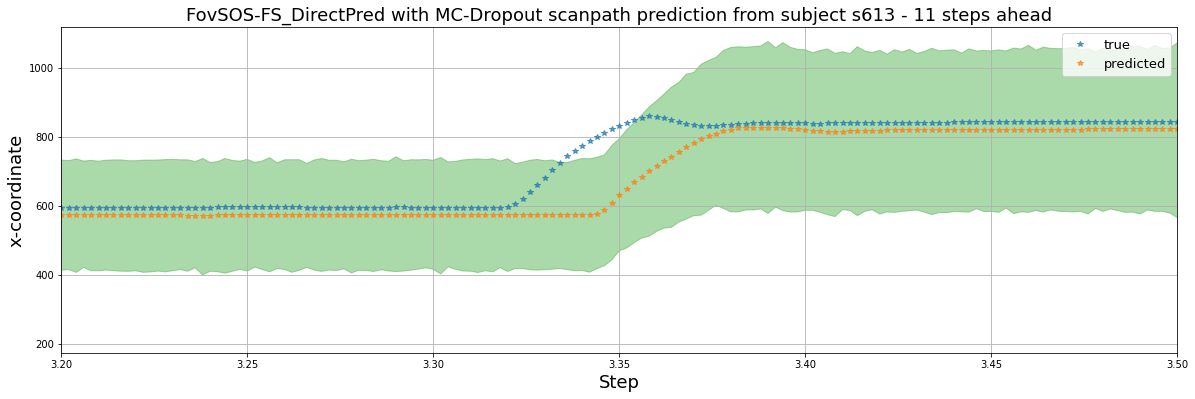

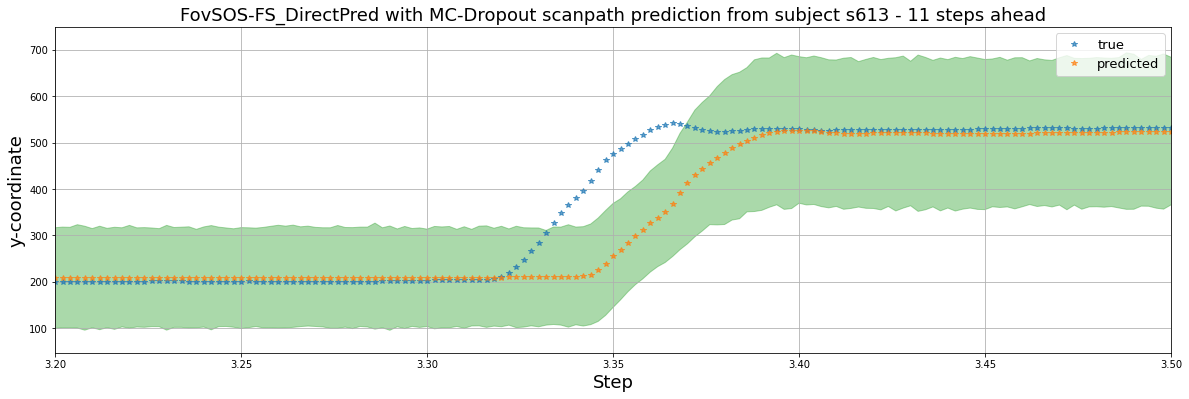

In [18]:
#percentile = 70
if params.N_MC_SAMPLES:
    for x_or_y in ["x", "y"]:
        plt.figure(figsize=(20,6))
        plt.plot(y_real[x_or_y].index*2/1000, y_real[x_or_y], 'C0*', label='true', alpha=0.7)
        plt.plot(y_pred[x_or_y].index*2/1000, y_pred[x_or_y], 'C1*', label='predicted', alpha=0.7)
        # Plot mean std
        if params.N_MC_SAMPLES:
            plt.fill_between(y_real[x_or_y].index*2/1000, mcdropout_mean[x_or_y] - 3*mcdropout_std[x_or_y],
                         mcdropout_mean[x_or_y] + 3*mcdropout_std[x_or_y], color='C2', alpha=0.4)
        # Plot percentile
        #plt.plot(np.percentile(lstm_mcdropout_pred, q=percentile, axis=0)[:, 0 if x_or_y == "x" else 1],'C3', label=f'Percentile {percentile}', alpha=0.7)

        plt.legend(loc='best', prop={'size': 13})
        if params.N_MC_SAMPLES:
            title = f'{model_name} with MC-Dropout scanpath prediction from subject {SUBJECT} - {HORIZON} steps ahead'
        else:
            title = f'{model_name} scanpath prediction from subject {SUBJECT} - {HORIZON} steps ahead'
        plt.title(title, fontsize=18)
        plt.grid()
        plt.ylabel(f"{x_or_y}-coordinate", fontsize=18)
        plt.xlabel("Step", fontsize=18)
        #plt.xlim(1100, 1440)
        #plt.xlim(700, 750)
        plt.xlim(3.2, 3.5)
        plt.show()

Cross-Corellation Peak on 20 for x
Cross-Corellation Peak on 15 for y


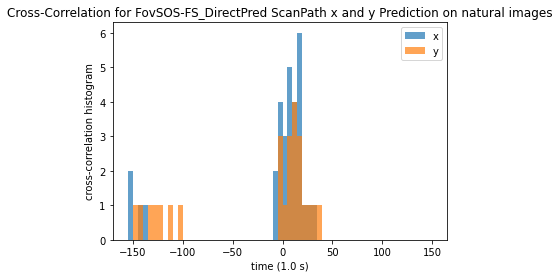

In [19]:
for x_or_y in ["x", "y"]:
    cc_hist, peak = get_cross_correlation_histogram(y_real[x_or_y].values, y_pred[x_or_y].values)
    
    plt.bar(x=cc_hist[0].times.magnitude,
            height=cc_hist[0][:, 0].magnitude.squeeze(),
            width=cc_hist[0].sampling_period.magnitude,
            label=x_or_y,
            alpha=0.7)
    plt.xlabel(f'time ({cc_hist[0].times.units})')
    plt.ylabel('cross-correlation histogram')
    # Plot LSTM Prediction for x
    plt.title(f"Cross-Correlation for {model_name} ScanPath x and y Prediction on natural images")
    print(f"Cross-Corellation Peak on {peak} for {x_or_y}")
plt.legend()
plt.show()

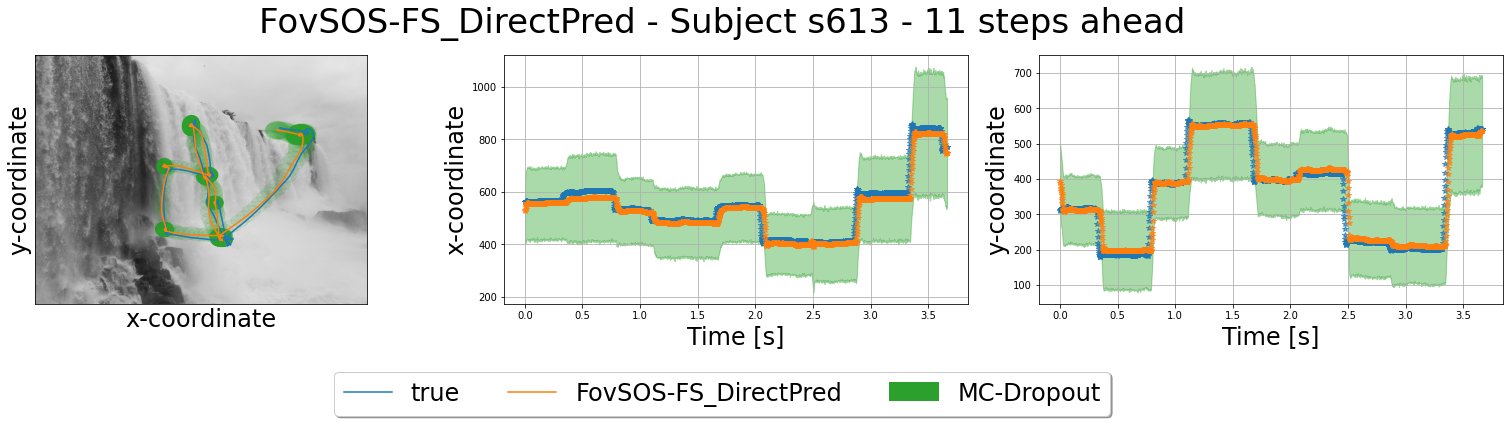

In [20]:
calculate_mcdropout = True

import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

if calculate_mcdropout:

    if params.N_MC_SAMPLES:
        ellipses = []
        for mean, std in zip(mcdropout_mean.values, mcdropout_std.values):
            ellipse = matplotlib.patches.Ellipse(
                (mean[0], mean[1]), 
                std[0], std[1], alpha=0.1, color='C2')
            ellipses.append(ellipse)

    fig, ax = plt.subplots(1,3,figsize=(22,5))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel("x-coordinate", fontsize=24)
    ax[0].set_ylabel("y-coordinate", fontsize=24)
    ax[0].set_xlim(0, params.data_params.WIDTH)
    ax[0].set_ylim(0, params.data_params.HEIGHT)
    line1, = ax[0].plot(0, 0)
    line2, = ax[0].plot(0, 0)
    line1.set_label("true")
    line2.set_label(model_name)
    line1.set_color("C0")
    line2.set_color("C1")
    #ax[0].legend()
    img = cv2.imread("../diagrams/image_types/casc_li.jpg")[::-1]
    img = cv2.resize(img, (data_params.WIDTH, data_params.HEIGHT))
    #img = np.flipud(plt.imread(img_tests[0]))
    ax[0].imshow(img)
    line1.set_xdata(y_real["x"])
    line1.set_ydata(y_real["y"])
    line2.set_xdata(y_pred["x"])
    line2.set_ydata(y_pred["y"])
    if params.N_MC_SAMPLES:
        for ellipse in ellipses:
            new_e = copy(ellipse)
            ax[0].add_patch(new_e)
    
    if params.N_MC_SAMPLES:
        handles, labels = ax[0].get_legend_handles_labels()
        patch = mpatches.Patch(color='C2', label='MC-Dropout', linewidth=2)
        handles.append(patch) 
        #ax[0].legend(handles=handles)

    for i, x_or_y in enumerate(["x", "y"]):
        time_index = y_real.index*2/1000
        ax[i+1].plot(time_index, y_real[x_or_y], 'C0*', alpha=0.7)
        ax[i+1].plot(time_index, y_pred[x_or_y], 'C1*', alpha=0.7)
        # Plot mean std
        if params.N_MC_SAMPLES:
            ax[i+1].fill_between(time_index, mcdropout_mean[x_or_y] - 3*mcdropout_std[x_or_y],
                             mcdropout_mean[x_or_y] + 3*mcdropout_std[x_or_y], color='C2', alpha=0.4)
        #plt.legend(loc='best', prop={'size': 13})
        ax[i+1].grid()
        ax[i+1].set_ylabel(f"{x_or_y}-coordinate", fontsize=24)
        ax[i+1].set_xlabel("Time [s]", fontsize=24)
    #if params.N_MC_SAMPLES:
    #    title = f'{model_name} with MC-Dropout scanpath prediction from subject {SUBJECT} - {HORIZON} steps ahead'
    #else:
    #    title = f'{model_name} scanpath prediction from subject {SUBJECT} - {HORIZON} steps ahead'
    title = f'{model_name} - Subject {SUBJECT} - {HORIZON} steps ahead'
    fig.suptitle(title, fontsize=34)
    fig.tight_layout()
    if HORIZON == 11:
        if params.N_MC_SAMPLES:
            fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.0), #bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=3, prop={'size': 24})
        else:
            fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), #bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=3, prop={'size': 24})
    if params.is_save:
    #if True:
        savepath = SAVE_FOLDER
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        fig.savefig(f"{os.path.join(savepath, f'{SUBJECT}_{HORIZON}_mcdropout_fix')}.png", bbox_inches='tight')
    plt.show()

In [21]:
calculate_mcdropout = True

import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

if calculate_mcdropout:

    if params.N_MC_SAMPLES:
        ellipses = []
        for mean, std in zip(mcdropout_mean.values, mcdropout_std.values):
            ellipse = matplotlib.patches.Ellipse(
                (mean[0], mean[1]), 
                std[0], std[1], alpha=0.1, color='C2')
            ellipses.append(ellipse)

    fig, ax = plt.subplots(1,3,figsize=(22,5))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel("x-coordinate", fontsize=18)
    ax[0].set_ylabel("y-coordinate", fontsize=18)
    ax[0].set_xlim(0, params.data_params.WIDTH)
    ax[0].set_ylim(0, params.data_params.HEIGHT)
    line1, = ax[0].plot(0, 0)
    line2, = ax[0].plot(0, 0)
    line1.set_label("true")
    line2.set_label(model_name)
    line1.set_color("C0")
    line2.set_color("C1")
    ax[0].legend()
    img = cv2.imread("../diagrams/image_types/casc_li.jpg")[::-1]
    img = cv2.resize(img, (data_params.WIDTH, data_params.HEIGHT))
    #img = np.flipud(plt.imread(img_tests[0]))
    ax[0].imshow(img)
    line1.set_xdata(y_real["x"])
    line1.set_ydata(y_real["y"])
    line2.set_xdata(y_pred["x"])
    line2.set_ydata(y_pred["y"])
    if params.N_MC_SAMPLES:
        for ellipse in ellipses:
            new_e = copy(ellipse)
            ax[0].add_patch(new_e)
    if params.N_MC_SAMPLES:
        handles, labels = ax[0].get_legend_handles_labels()
        patch = mpatches.Patch(color='C2', label='MC-Dropout', linewidth=2)
        handles.append(patch) 
        ax[0].legend(handles=handles)


    for i, x_or_y in enumerate(["x", "y"]):
        time_index = y_real.index*2/1000
        ax[i+1].plot(time_index, y_real[x_or_y], 'C0*', label='true', alpha=0.7)
        ax[i+1].plot(time_index, y_pred[x_or_y], 'C1*', label='predicted', alpha=0.7)
        # Plot mean std
        if params.N_MC_SAMPLES:
            ax[i+1].fill_between(time_index, mcdropout_mean[x_or_y] - 3*mcdropout_std[x_or_y],
                             mcdropout_mean[x_or_y] + 3*mcdropout_std[x_or_y], color='C2', alpha=0.4)
        #plt.legend(loc='best', prop={'size': 13})
        ax[i+1].grid()
        ax[i+1].set_ylabel(f"{x_or_y}-coordinate", fontsize=18)
        ax[i+1].set_xlabel("Time [s]", fontsize=18)
    if params.N_MC_SAMPLES:
        title = f'{model_name} with MC-Dropout scanpath prediction from subject {SUBJECT} - {HORIZON} steps ahead'
    else:
        title = f'{model_name} scanpath prediction from subject {SUBJECT} - {HORIZON} steps ahead'
    fig.suptitle(title, fontsize=18)
    fig.tight_layout()
    if params.is_save:
        savepath = SAVE_FOLDER
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        fig.savefig(f"{os.path.join(savepath, f'{SUBJECT}_{HORIZON}_mcdropout')}.png")
    plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f69b7221290> (for post_execute):


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(0, data_params.WIDTH)
ax.set_ylim(0, data_params.HEIGHT)
ax.set_xticks([])
ax.set_yticks([])
line1, = ax.plot(0, 0)
line2, = ax.plot(0, 0)
line1.set_label("true")
line2.set_label("pred")
line1.set_color("C0")  
line2.set_color("C1")
plt.legend()
plt.title(f'{model_name} - subject {SUBJECT} - {HORIZON} steps ahead')
img = cv2.imread("../diagrams/image_types/casc_li.jpg")[::-1]
img = cv2.resize(img, (data_params.WIDTH, data_params.HEIGHT))
#img = np.flipud(plt.imread(img_tests[0]))
ax.imshow(img)


line2.set_data(y_pred["x"], y_pred["y"])
line1.set_data(y_real["x"], y_real["y"])

In [ ]:
displace_pred = HORIZON

y_pred_video = y_pred.reset_index(drop=True)
y_pred_video.index = range(displace_pred, y_pred_video.shape[0]+displace_pred)
y_real_video = y_real.reset_index(drop=True)
y_real_video.index = range(HORIZON, y_real_video.shape[0]+HORIZON)
X_test_img = X_test[i_img]

In [ ]:
create_video = False

In [ ]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Scan-Paths Prediction', artist='Camilo Jara',
                comment='Scan-Paths')
writer = FFMpegWriter(fps=5, metadata=metadata)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Figure config
fig, ax = plt.subplots(1,3,figsize=(22,5))
ax[0].set_xlabel("x-coordinate", fontsize=16)
ax[0].set_ylabel("y-coordinate", fontsize=16)
ax[0].set_xlim(0, data_params.WIDTH)
ax[0].set_ylim(0, data_params.HEIGHT)
ax[1].set_xlabel("Time [s]", fontsize=16)
ax[1].set_ylabel("x-coordinate", fontsize=16)
ax[1].set_xlim(0, y_real_video.shape[0]*2/1000)
ax[1].set_ylim(0, data_params.WIDTH)
ax[1].grid()
ax[2].set_xlabel("Time [s]", fontsize=16)
ax[2].set_ylabel("y-coordinate", fontsize=16)
ax[2].set_xlim(0, y_real_video.shape[0]*2/1000)
ax[2].set_ylim(0, data_params.HEIGHT)
ax[2].grid()

# Img lines
line1, = ax[0].plot(0, 0)
line2, = ax[0].plot(0, 0)
line2_steps_ahead, = ax[0].plot(0,0, "*", linewidth=3)
line2_input, = ax[0].plot(0,0, linewidth=2.2)
line1.set_label("true")
line2.set_label("pred")
line2_steps_ahead.set_label(f"{HORIZON}-steps ahead")
line2_input.set_label("input")
line1.set_color("C0")  
line2.set_color("C1")
line2_steps_ahead.set_color("C2")
line2_input.set_color("C3")
# x-coord lines
line3, = ax[1].plot(0, 0)
line4, = ax[1].plot(0, 0)
line4_steps_ahead, = ax[1].plot(0,0, "*", linewidth=3)
line4_input, = ax[1].plot(0,0, linewidth=2.2)
line3.set_color("C0")
line4.set_color("C1")
line4_steps_ahead.set_color("C2")
line4_input.set_color("C3")
# y-coord lines
line5, = ax[2].plot(0, 0)
line6, = ax[2].plot(0, 0)
line6_steps_ahead, = ax[2].plot(0,0, "*", linewidth=3)
line6_input, = ax[2].plot(0,0, linewidth=2.2)
line5.set_color("C0")
line6.set_color("C1")
line6_steps_ahead.set_color("C2")
line6_input.set_color("C3")

# Plot config
ax[0].legend()   
v1 = ax[1].axvline(x=0, ymin=0, ymax=data_params.HEIGHT, color="k", linestyle="--")
v2 = ax[2].axvline(x=0, ymin=0, ymax=data_params.HEIGHT, color="k", linestyle="--")
img = cv2.imread("../diagrams/image_types/casc_li.jpg")[::-1] #img = np.flipud(plt.imread(img_tests[0]))
img = cv2.resize(img, (data_params.WIDTH, data_params.HEIGHT))
ax[0].imshow(img)
fig.suptitle(f'{model_name} - subject {SUBJECT} - {HORIZON} steps ahead', fontsize=18)

def format_input(i, X_test_img):
    input_data = pd.DataFrame(scaler.inverse_transform(X_test_img[i]))[[0, 1]]
    input_data.columns = ["x", "y"]
    input_data.index = (i + input_data.index - timeseries_params.SEQ_LENGTH)
    return input_data
  
def animation_frame(i):
    min_lim = 0.3
    max_lim = 0.05
    timestep = i*2/1000
    # Input data
    input_data = format_input(i, X_test_img)
    # Image plot
    line1.set_data(y_real_video.loc[:i]["x"], y_real_video.loc[:i]["y"])
    line2.set_data(y_pred_video.loc[:i]["x"], y_pred_video.loc[:i]["y"])
    #line2_steps_ahead.set_data(y_pred_video.iloc[i-2:i]["x"], y_pred_video.iloc[i-2:i]["y"])
    line2_steps_ahead.set_data(y_pred_video.iloc[i-1:i]["x"], y_pred_video.iloc[i-1:i]["y"])
    # x-coord plot
    real_x = y_real_video["x"].iloc[:i]
    pred_x = y_pred_video["x"].iloc[:i]
    ax[1].set_xlim(timestep-min_lim, timestep+max_lim)
    v1.set_xdata([timestep, timestep])
    line3.set_data(real_x.index*2/1000, real_x)
    line4.set_data(pred_x.index*2/1000, pred_x)
    line4_steps_ahead.set_data(real_x.iloc[-1:].index*2/1000, pred_x.iloc[-1:])
    #line4_steps_ahead.set_data((pred_x.iloc[-1:].index+HORIZON-1)*2/1000, pred_x.iloc[-1:])
    line4_input.set_data(input_data.index*2/1000, input_data["x"])
    # y-coord plot    
    real_y = y_real_video["y"].iloc[:i]
    pred_y = y_pred_video["y"].iloc[:i]
    ax[2].set_xlim(timestep-min_lim, timestep+max_lim)
    v2.set_xdata([timestep, timestep])
    line5.set_data(real_y.index*2/1000, real_y)
    line6.set_data(pred_y.index*2/1000, pred_y)
    line6_steps_ahead.set_data(real_y.iloc[-1:].index*2/1000, pred_y.iloc[-1:])
    line6_input.set_data(input_data.index*2/1000, input_data["y"])
    return line1, line2, line2_steps_ahead, line3, line4, line4_steps_ahead, line4_input, line5, line6, line6_steps_ahead, line6_input,

if create_video:
    animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, len(y_real_video), 1), interval=2)
    animation.save(f'{model_name}-{SUBJECT}-N_{HORIZON}.mp4', writer=writer)

In [ ]:
"""import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(0, data_params.WIDTH)
ax.set_ylim(0, data_params.HEIGHT)
ax.set_xticks([])
ax.set_yticks([])
line1, = ax.plot(0, 0)
line2, = ax.plot(0, 0)
line1.set_label("true")
line2.set_label("pred")
line1.set_color("C0")  
line2.set_color("C1")
plt.legend()
plt.title(f'{model_name} - subject {SUBJECT} - {HORIZON} steps ahead')
img = cv2.imread("../diagrams/image_types/casc_li.jpg")[::-1]
img = cv2.resize(img, (data_params.WIDTH, data_params.HEIGHT))
#img = np.flipud(plt.imread(img_tests[0]))
ax.imshow(img)

def animation_frame(i):
    line2.set_xdata(y_pred.iloc[:i]["x"])
    line2.set_ydata(y_pred.iloc[:i]["y"])
    line1.set_xdata(y_real.iloc[:i]["x"])
    line1.set_ydata(y_real.iloc[:i]["y"])
    return line1, line2,  

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, len(y_real), 1), interval=10)
animation.save(f'{model_name}-{SUBJECT}-N_{HORIZON}.mp4', writer=writer)"""